# Different ways to do background correction
Background correction is an optional step in the analysis pipeline, and is used to remove static elements in an image for improved analysis results.

In PyOpia there are several ways to use the background correction functionality, illustrated in this notebook.

In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

import pyopia.exampledata
from pyopia.pipeline import Pipeline


In [2]:
# Obtain example image files
image_input_folder = pyopia.exampledata.get_oil_from_pysilcam_blob()

./oil_silcam_images already exists. Returning nothing


In [3]:
# These imports are indirectly needed for the Pipeline
import pyopia.background
import pyopia.instrument.silcam

# Manually define PyOpia pipeline configuration
NUM_IMAGES_FOR_BACKGROUND = 5

pipeline_config = {
   'general': {
      'raw_files': f'{image_input_folder}/*.silc',
      'pixel_size': 24 # pixel size in um 
   },
 'steps': {
      ### start of steps applied to every image
      # load the image using instrument-specific loading function 
      'load': {
         'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'
      },
      # apply background correction - argument is which method to use:
      # 'accurate' - recommended method for moving background
      # 'fast' - faster method for realtime applications
      # 'pass' - omit background correction
      'correctbackground': {
         'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
         'average_window': NUM_IMAGES_FOR_BACKGROUND,
         'bgshift_function': 'accurate'
      }
   }
}

# now initialise the pipeline
processing_pipeline = Pipeline(pipeline_config)

Initialising pipeline


# Create a background from multiple images

In [4]:
# The background stack (of raw images) and background image (mean of bgstack) is built during the first
# N run steps of the pipeline. During this process, further analysis steps are skipped.

# Get a sorted list of image files
image_files = sorted(glob(pipeline_config['general']['raw_files']))
print(f'Found {len(image_files)} image files')

# Process first N images to create the background.
for filename in image_files[:NUM_IMAGES_FOR_BACKGROUND]:
    processing_pipeline.run(filename)

Found 15 image files
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename'])
CorrectBackgroundAccurate  ready with: {'average_window': 5, 'bgshift_function': 'accurate'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw'])
Skipping remaining steps of the pipeline and returning
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
CorrectBackgroundAccurate  ready with: {'average_window': 5, 'bgshift_function': 'accurate'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
Skipping remaining steps of the pipeline and returning
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
CorrectBackgroundAccurate  ready with

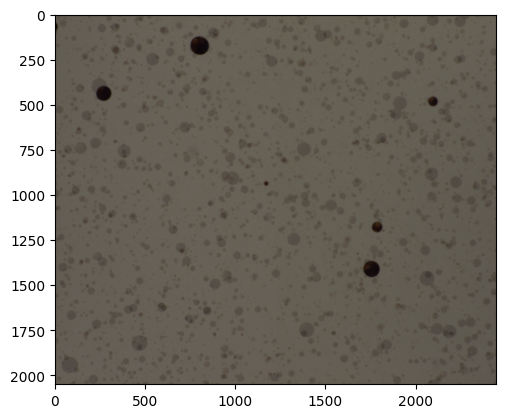

In [5]:
# Inspect the background image 
fig, ax = plt.subplots()
ax.imshow(processing_pipeline.data['imbg'])

# Run background correction on a single image

In [6]:
# Process one image using the already prepared background of the first N images
# NB: Each time you call run(), the background stack and background image will be updated! (Unless 'pass' was set as bgshift_function - see below)
processing_pipeline.run(image_files[NUM_IMAGES_FOR_BACKGROUND])

SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
CorrectBackgroundAccurate  ready with: {'average_window': 5, 'bgshift_function': 'accurate'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])


Text(0.5, 1.0, 'Background corrected image')

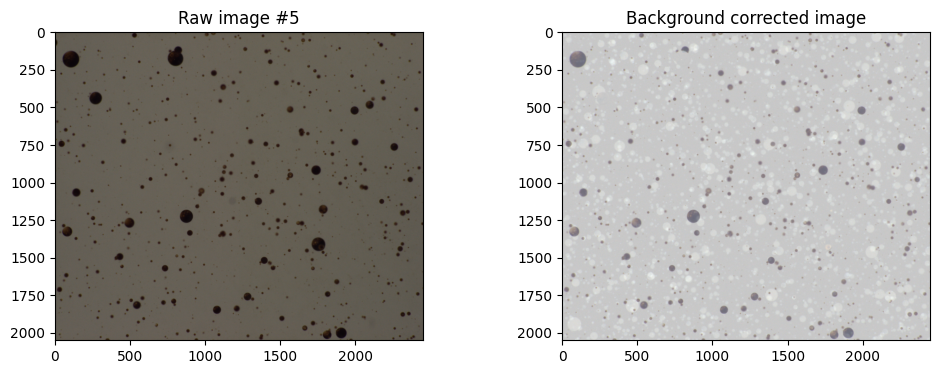

In [7]:
# Plot raw and corrected image
fig, axes = plt.subplots(1, 2, figsize=(2*6, 4))
axes[0].imshow(processing_pipeline.data['imraw'])
axes[0].set_title(f'Raw image #{NUM_IMAGES_FOR_BACKGROUND}')
axes[1].imshow(processing_pipeline.data['im_corrected'])
axes[1].set_title('Background corrected image')

# Static vs running average background
The CorrectBackgroundAccurate class have two different modes for a dynamic (running) background correction (bgshift_function either 'fast' and 'accurate'), 
and one mode for a static background that is created once and then not updated (bgshift_function='pass').
The static background is set up in the same way as the dynamic one, by the N initial calls to the pipeline run. 
You can choose how many and which images to use for the background, illustrated below.

In [8]:
# Recreate pipeline and update background step config for static background correction
processing_pipeline = Pipeline(processing_pipeline.settings)
processing_pipeline.settings['steps'].update(
    {
        'correctbackground':
             {
                'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
                'average_window': NUM_IMAGES_FOR_BACKGROUND,
                'bgshift_function': 'pass'
            }
    }
)

# Process first N images to create the static background.
for filename in image_files[:NUM_IMAGES_FOR_BACKGROUND]:
    processing_pipeline.run(filename)

# With a static background, the processing order does not matter, so we can for instance process the last image in the list.
# Now processing an image will not cause the background to be updated
imbg_before = processing_pipeline.data['imbg'].copy()
processing_pipeline.run(image_files[-1])

# Check difference in imbg before and after analysis step, should be zero
np.abs(imbg_before - processing_pipeline.data['imbg']).sum()


Initialising pipeline
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename'])
CorrectBackgroundAccurate  ready with: {'average_window': 5, 'bgshift_function': 'pass'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw'])
Skipping remaining steps of the pipeline and returning
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
CorrectBackgroundAccurate  ready with: {'average_window': 5, 'bgshift_function': 'pass'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
Skipping remaining steps of the pipeline and returning
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
CorrectBackgroundAccurate  ready with: {'ave

0.0

In [9]:
# Static background correction using average of ALL images in the list

# Custom background correction
You can write your own custom background correction class, here is a simple example of how to do that.



In [10]:
class MyCustomBackgroundClass():
    '''
    Example custom background class: use a randomly generated image to "correct" the background
    '''

    def __call__(self, data):
        # Create a random background image
        data['imbg'] = np.random.random(data['imraw'].shape)
        data['bgstack'] = [data['imbg']]

        # Correct
        data['im_corrected'] = np.maximum(data['imraw'] - data['imbg'], 0)

        # Stretch contrast
        data['im_corrected'] = rescale_intensity(data['im_corrected'], out_range=(0, 1))

        return data


# Monkey patch the custom class into PyOpia
pyopia.background.MyCustomBackgroundClass = MyCustomBackgroundClass

In [11]:
# Recreate pipeline and update background step config with cutsom background correction
processing_pipeline = Pipeline(processing_pipeline.settings)
processing_pipeline.settings['steps'].update(
    {
        'correctbackground':
             {
                'pipeline_class': 'pyopia.background.MyCustomBackgroundClass',
            }
    }
)

processing_pipeline.run(image_files[0])

Initialising pipeline
SilCamLoad  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename'])
MyCustomBackgroundClass  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'filename', 'timestamp', 'imraw'])


Text(0.5, 1.0, 'Background corrected image')

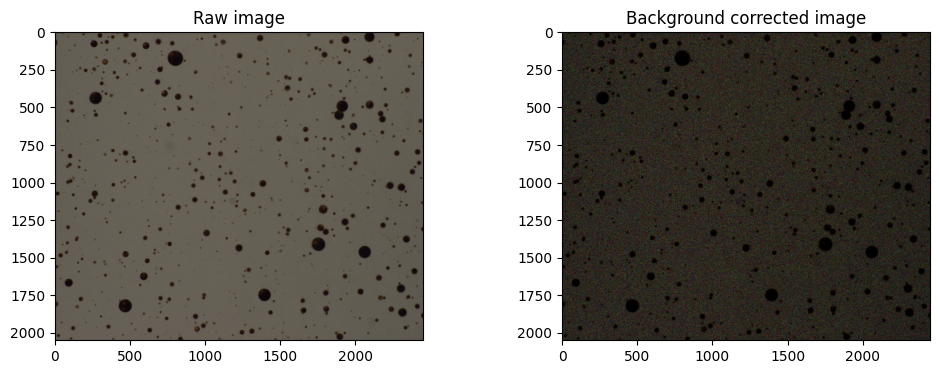

In [12]:
# Plot raw and corrected image
fig, axes = plt.subplots(1, 2, figsize=(2*6, 4))
axes[0].imshow(processing_pipeline.data['imraw'])
axes[0].set_title('Raw image')
axes[1].imshow(processing_pipeline.data['im_corrected'])
axes[1].set_title('Background corrected image')